<h1 style="font-size: 48px;">Harmonic balance method </h1>
In this juypyter notebook we are testing Harmonic Balance method for a simple advection problem. 
There is no diffusion. The velocity is constant. Sine wave is generated in the left boundary. It travels and passes throught the right boundary.  Harmonic balance method is implemented similar to this publication.

https://www.researchgate.net/profile/Gregor-Cvijetic/publication/309328469_Finite_Volume_Implementation_of_the_Harmonic_Balance_Method_for_Periodic_Non-Linear_Flows/links/59d498594585150177fc5a1b/Finite-Volume-Implementation-of-the-Harmonic-Balance-Method-for-Periodic-Non-Linear-Flows.pdf

In [21]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.sparse.linalg as la
import scipy.sparse as sparse
import time as tm
import logging
from scipy.sparse import diags
from scipy.sparse import csr_matrix

# creating matrix called $P_i$ 

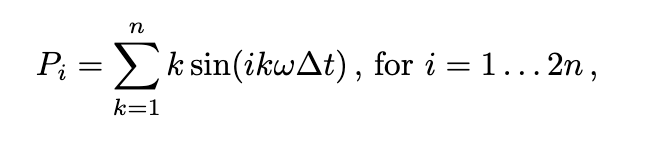
Equation (17) from the publication

In [22]:
def P_i(i,f,n):
    w = 2 * np.pi * f
    T = 1 / f
    k = np.arange(n) + 1
    dt = T / (2 * n + 1) # given in the paper Equation (18)
    return np.sum(k * np.sin(i * k * w * dt))

# creating $E^{-1}AE$ matrix

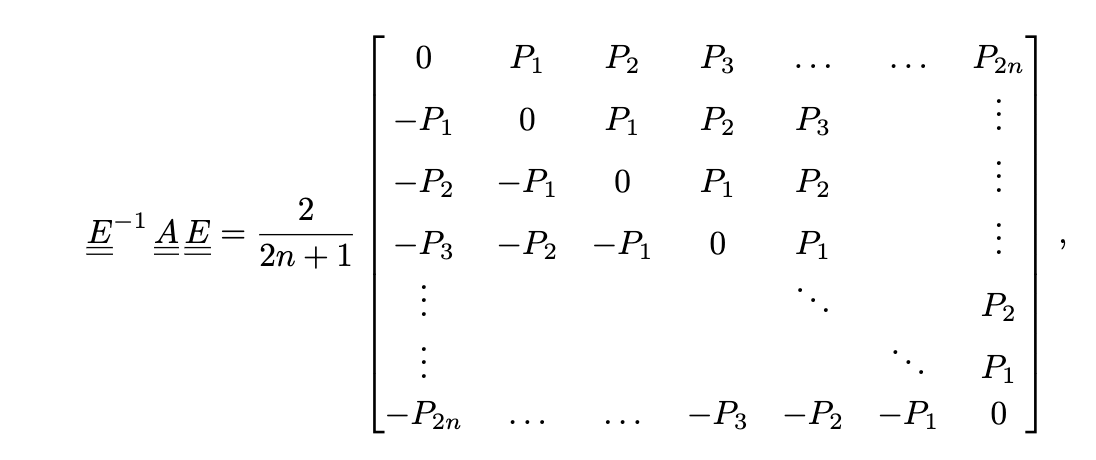
Equation (16) from the publication

In [23]:
def EAE(f,n):
    w = 2 * np.pi * f
    retMatrix = np.ones((2 * n + 1, 2 * n + 1), dtype = float)
    for a in np.arange(2 * n + 1):
        for b in np.arange(2 * n + 1):
            retMatrix[a,b] = np.sign(b-a) * P_i(abs(b-a),f,n)
    return (2 * w  / (2 * n + 1)) * retMatrix

# Harmonic Balance operator LHS without the divergence term

In [24]:
def harmonicOperatorMatrix(f,nn):
    n = (2 * nn + 1) ** 2
    sparse_matrix = csr_matrix((n, n), dtype=float)
    
    eae = (EAE(f,nn))
    
    for a in np.arange(2*nn+1):
        diagg_up = np.zeros(((np.diag(eae,-a).size))*(2*nn+1))
        diagg_down = np.zeros(((np.diag(eae,-a).size))*(2*nn+1))
        for rc in np.arange(np.diag(eae,-a).size):
            curdiag_up = np.diag(eae,a)
            curdiag_down = np.diag(eae,-a)
            diagg_up[1+2*rc+rc*(2*nn + 1 - 2):1+2*rc+(rc+1)*(2*nn + 1 - 2)] = curdiag_up[rc]
            diagg_down[1+2*rc+rc*(2*nn + 1 - 2):1+2*rc+(rc+1)*(2*nn + 1 - 2)] = curdiag_down[rc]
        
        diagonal_matrix_up = diags(diagg_up, offsets=(a*(2*nn+1)), shape=(n, n), format='csr')
        diagonal_matrix_down = diags(diagg_down, offsets=-(a*(2*nn+1)), shape=(n, n), format='csr')
        sparse_matrix = sparse_matrix + diagonal_matrix_up + diagonal_matrix_down

    return sparse_matrix

# Printing HB operator

In [25]:
n=50
harmonicOperatorMatrix(1,n)

<10201x10201 sparse matrix of type '<class 'numpy.float64'>'
	with 999900 stored elements in Compressed Sparse Row format>

# Divergence operator Matrix

In [26]:
def divergenceOperator(nn):
    n = (2 * nn + 1) ** 2
    sparse_matrix = csr_matrix((n, n), dtype=float)
        
    diagg_up = np.zeros(n )
    diagg_down = np.zeros(n - 1)
    for a in np.arange(2 * nn + 1):
        for b in np.arange(2 * nn + 1):
            strt = 2 * a + a * (2 * nn + 1 - 2)
            endd = 2 * a + (a + 1) * (2 * nn + 1 - 2)
            diagg_down[strt:endd] = 1

    diagg_up[1:-1] = - diagg_down[:-1]

    diagonal_matrix_up = diags(diagg_up, offsets=0, shape=(n, n), format='csr')
    diagonal_matrix_down = diags(diagg_down, offsets=-1, shape=(n, n), format='csr')
    sparse_matrix = sparse_matrix + diagonal_matrix_up + diagonal_matrix_down
    
    return sparse_matrix

# laplacian operator

In [27]:
def laplacianeOperator(nn):
    n = (2 * nn + 1) ** 2
    sparse_matrix = csr_matrix((n, n), dtype=float)
        
    diagg_up = np.zeros(n - 1)
    diagg_down = np.zeros(n - 1)
    diagg_main = np.zeros(n + 1)
    for a in np.arange(2 * nn + 1):
        for b in np.arange(2 * nn + 1):
            strt = 2 * a + a * (2 * nn + 1 - 2)
            endd = 2 * a + (a + 1) * (2 * nn + 1 - 2)
            diagg_down[strt:endd] = -1
            diagg_main[1+strt:1+endd] = 2

    diagg_up[1:] =  diagg_down[:-1]

    diagonal_matrix_up = diags(diagg_up, offsets=1, shape=(n, n), format='csr')
    diagonal_matrix_down = diags(diagg_down, offsets=-1, shape=(n, n), format='csr')
    diagonal_matrix_main = diags(diagg_main, offsets=0, shape=(n, n), format='csr')
    print(diagonal_matrix_main)
    sparse_matrix = sparse_matrix + diagonal_matrix_up + diagonal_matrix_down + diagonal_matrix_main
    
    return sparse_matrix

In [28]:
divergenceOperator(50)

<10201x10201 sparse matrix of type '<class 'numpy.float64'>'
	with 19998 stored elements in Compressed Sparse Row format>

# BC operator Matrix

In [29]:
def BCOperatorMatrix(nn):
    n = (2 * nn + 1) ** 2
    sparse_matrix = csr_matrix((n, n), dtype=float)
    
    diagg = np.ones(n)
    for a in np.arange(2 * nn + 1):
        for b in np.arange(2 * nn + 1):
            strt = 1 + 2 * a + a * (2 * nn + 1 - 2)
            endd = 1 + 2 * a + (a + 1) * (2 * nn + 1 - 2)
            diagg[strt:endd] = 0
            
    diagonal_matrix = diags(diagg, offsets=0, shape=(n, n), format='csr')
    sparse_matrix = sparse_matrix + diagonal_matrix
    
    return sparse_matrix

In [30]:
BCOperatorMatrix(50)

<10201x10201 sparse matrix of type '<class 'numpy.float64'>'
	with 202 stored elements in Compressed Sparse Row format>

# Sine wave test case 

## fluid model

In [31]:
#ADVECTION SOLVING MATRIX (1D FINITE VOLUME METHOD) ==========================================================
def AdvectionAlgorithm(dx,dt,velocity,density):
    #this is a simple yet very efficient code that solves the advection of the particles using FVM
    flux = (0.5*(velocity[1:]*density[1:]+velocity[:-1]*density[:-1])-
            0.5*0.5*abs(velocity[1:]+velocity[:-1])*(density[1:]-density[:-1]))*dt
    density[1:-1] += -(flux[1:]-flux[:-1])/dx
    return density[1:-1]

In [32]:
# central difference method
def AdvectionAlgorithmFD(dx,dt,velocity,density):
    density[1:-1] += -dt*(velocity[1:-1]*density[1:-1]-velocity[:-2]*density[:-2])/dx
    return density[1:-1]

## test case finite volume

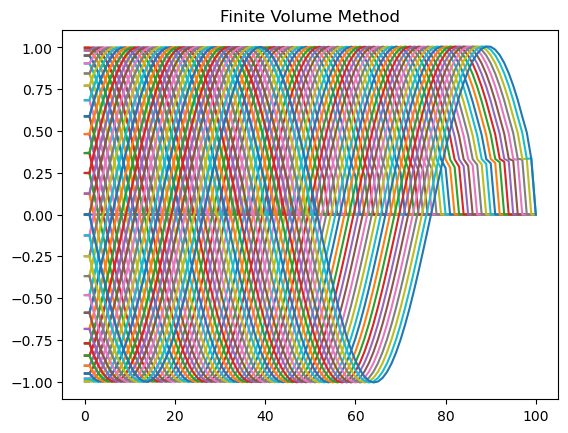

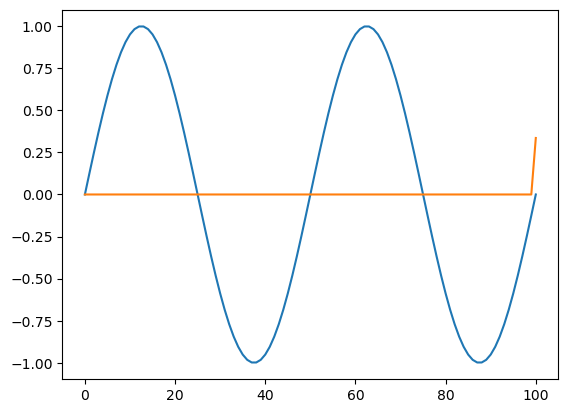

In [33]:
distance = 1 # meters
frequency = 20 # hertz
velocity = 10 #m/s
grid = 101 # 50cells total
timesteps = 101
amplitude = 1 # 1 meters

#matrices
densityM = 0.000001*np.ones(grid)
#print(wave)
xvalueM = np.arange(grid)/grid
#print(xvalue)
velocityM = velocity * np.ones(grid)
dx = xvalueM[1]-xvalueM[0]
dt = 0.001


bcvalL = np.zeros(timesteps)
bcvalR = np.zeros(timesteps)
for t in np.arange(timesteps):
    time = t * dt
    densityM[0] = amplitude * np.sin(2 * np.pi*frequency * time)
    bcvalL[t] = densityM[0]
    bcvalR[t] = densityM[-2]
    densityM[1:-1] = (AdvectionAlgorithm(dx,dt,velocityM,densityM))
    plt.plot(densityM)
    #plt.show()

plt.title("Finite Volume Method")
plt.show()

plt.plot(bcvalL)
plt.plot(bcvalR)
plt.show()

## test case forward difference (similar to upwinding because velocity is positive)

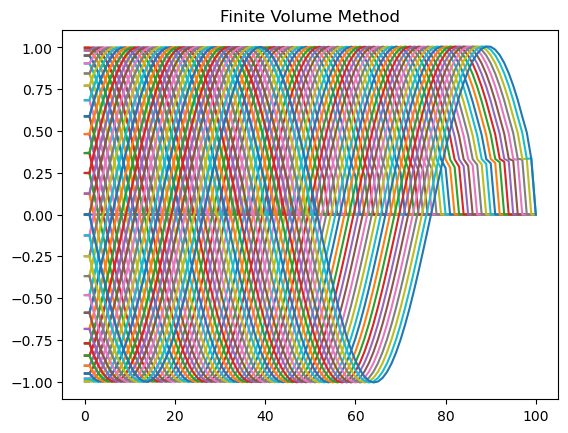

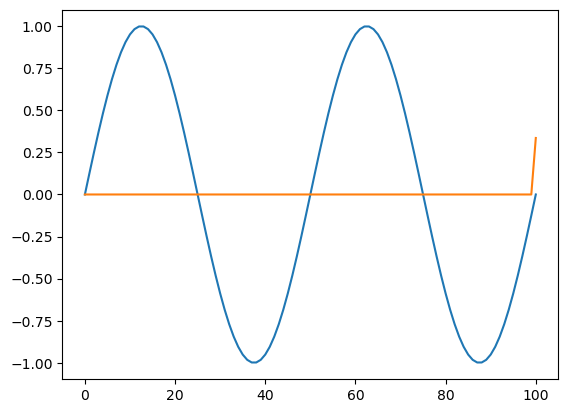

In [34]:
distance = 1 # meters
frequency = 20 # hertz
velocity = 10 #m/s
grid = 101 # 50cells total
timesteps = 101
amplitude = 1 # 1 meters

#matrices
densityM = 0.000001*np.ones(grid)
#print(wave)
xvalueM = np.arange(grid)/grid
#print(xvalue)
velocityM = velocity * np.ones(grid)
dx = xvalueM[1]-xvalueM[0]
dt = 0.001


bcvalL = np.zeros(timesteps)
bcvalR = np.zeros(timesteps)
for t in np.arange(timesteps):
    time = t * dt
    densityM[0] = amplitude * np.sin(2 * np.pi*frequency * time)
    bcvalL[t] = densityM[0]
    bcvalR[t] = densityM[-2]
    densityM[1:-1] = (AdvectionAlgorithmFD(dx,dt,velocityM,densityM))
    plt.plot(densityM)
    #plt.show()

plt.title("Finite Volume Method")
plt.show()

plt.plot(bcvalL)
plt.plot(bcvalR)
plt.show()


# Harmonic Balance Method

## Creating the Operator 

In [35]:
distance = 1 # meters
frequency = 20 # hertz
velocity = 500 #m/s
amplitude = 1 # 1 meters
grid = 50 # 50cells total
n = grid

#matrices
xvalueM = np.arange(2*n+1)/(2*n+1)
dx = xvalueM[1]-xvalueM[0]
dt = 0.001





operator1 = harmonicOperatorMatrix(frequency,n)
operator2 = divergenceOperator(n)/(dx)*velocity
operator3 = BCOperatorMatrix(n)

operator = operator1 + operator2 + operator3

## creating the RHS matrix

In [36]:
RHS = np.zeros((2*n+1,2*n+1),float)
time = np.arange(2*n+1)*dt
RHS[:,0] = amplitude * np.sin(2 * np.pi*frequency * time)
RHS[:,-1] = -amplitude * np.sin(2 * np.pi*frequency * time)

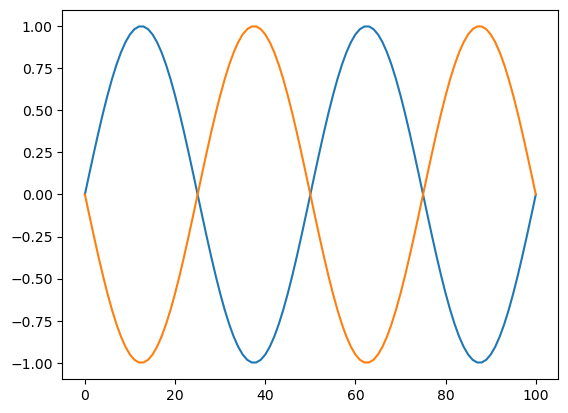

In [37]:
plt.plot(RHS[:,0])
plt.plot(RHS[:,-1])

In [38]:
RHS = RHS.reshape((2*n+1)**2)

In [39]:
print(RHS.shape)
print(operator.shape)

(10201,)
(10201, 10201)


## Solving the equation (HB method)

In [40]:
solution = la.spsolve(operator, RHS)

Text(0.5, 1.0, 'XT plot')

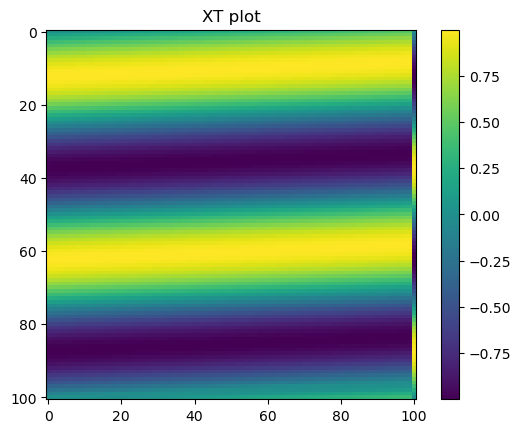

In [41]:
solution = solution.reshape(2*n+1,2*n+1)
plt.imshow(solution)
plt.colorbar()
plt.title("XT plot")

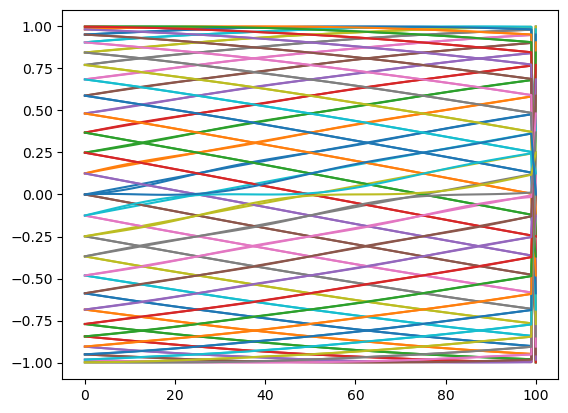

In [42]:
for a in np.arange(2*n+1):
    plt.plot(solution[a,:])

In [43]:
sparse_matrix = csr_matrix((3, 3), dtype=np.int8)

In [44]:
ns = 3
d1= np.arange(ns)

print(sparse_matrix.todense())

[[0 0 0]
 [0 0 0]
 [0 0 0]]


In [45]:
sparse_matrix = csr_matrix((3, 3), dtype=np.int8)
#diagonal_matrix = sparse.dia_matrix(([d1],[0],shape=(ns,ns)).tocsc() 


d0 = np.array([1,2,3])
d1 = np.array([4,5])
d2 = np.array([6,7])

diagonal_matrix = sparse.dia_matrix(([d0],[abs(0)]),shape=(ns,ns)).tocsc() 
sparse_matrix = sparse_matrix + diagonal_matrix


diagonal_matrix = sparse.dia_matrix(([d1],[1]),shape=(ns,ns)).tocsc() 
sparse_matrix = sparse_matrix + diagonal_matrix


diagonal_matrix = sparse.dia_matrix(([d2],[-abs(1)]),shape=(ns,ns)).tocsc() 
sparse_matrix = sparse_matrix + diagonal_matrix

print(sparse_matrix.todense())

[[1 5 0]
 [6 2 0]
 [0 7 3]]


In [46]:
from scipy.sparse import dia_matrix, csc_matrix

# Create a 5x5 sparse matrix with all elements zero
ns = 5
sparse_matrix = csc_matrix((ns, ns), dtype=int)

# Create the diagonal matrix with `d1` one position above the main diagonal
d1 = [1, 2, 3, 4]
diagonal_matrix = dia_matrix(([d1], [1]), shape=(ns, ns))

# Add the diagonal matrix to the sparse matrix
result_sparse_matrix = sparse_matrix + diagonal_matrix


In [47]:
print(result_sparse_matrix.todense())

[[0 2 0 0 0]
 [0 0 3 0 0]
 [0 0 0 4 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [48]:
import numpy as np
from scipy.sparse import diags

d1 = [1,2,3,4]
ns = len(d1) + 1  # ns is the number of rows and columns in the resulting sparse matrix

# create a sparse matrix with the diagonal offset at position 1
sparse_matrix = diags(d1, offsets=1, shape=(ns, ns), format='csr')

print(sparse_matrix.toarray())


[[0. 1. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 0. 0.]]


# transient heat equation

In [49]:
# Diffusion Operator
#============================================================================================================
def diffusionOperator(n,k1=-1,k2=0,k3=1):
	#create tridiagonal (n x n) matrix with -2 on the main diagonal and 1 above and below the main diag.
	d1 = np.zeros((n),float)
	d2 = np.ones((n),float)
	d3 = np.zeros((n),float)
	d1[:-2] = 1; d2[1:-1]=-2;d3[2:]=1
	return (sparse.dia_matrix(([d1,d2,d3],[k1,k2,k3]),shape=(n,n)).tocsc() ) 
#------------------------------------------------------------------------------------------------------------

4080
[[ 1.    0.    0.   ...  0.    0.    0.  ]
 [-0.25  1.5  -0.25 ...  0.    0.    0.  ]
 [ 0.   -0.25  1.5  ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  1.5  -0.25  0.  ]
 [ 0.    0.    0.   ... -0.25  1.5  -0.25]
 [ 0.    0.    0.   ...  0.    0.    1.  ]]


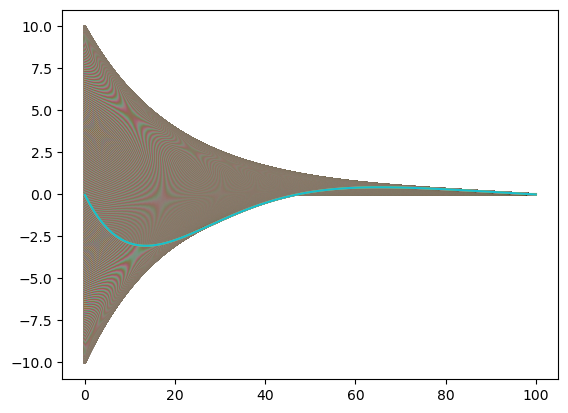

0.9999019703950593


In [50]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.sparse.linalg as la
import scipy.sparse as sparse
import time as tm
import logging
from scipy.sparse import diags
from scipy.sparse import csr_matrix

distance = 1 # meters
frequency = 1 # hertz
omega = 2 * np.pi * frequency

grid = 101 # cells total
amplitude = 10 # meters

#matrices
xvalueM = np.arange(grid)/grid
dx = xvalueM[1]-xvalueM[0]
diffusivity = 1e-1
dt = 0.25 * (dx * dx) / diffusivity 
r = dt * diffusivity / (dx * dx)

timesteps = int(1/dt)
print(timesteps)

# initialization
X = np.arange(grid) * dx  
T =  0*np.sin(2 * np.pi * X)


T[-1] = 0 


I = sparse.identity(grid, format='csr')
difop = diffusionOperator (grid) * r
operatorMat = I - difop
operatorMat[0, 0] = 1
operatorMat[-1, -1] = 1
hello = operatorMat.todense()
print(hello)

for time in np.arange(timesteps):
    T[0] =  amplitude * np.sin(omega * time * dt )
    T[-1] = 0
    T = la.spsolve(operatorMat, T)
    plt.plot(T)
plt.show() 
print(timesteps * dt)

# Harmonic Balance Method

  (1, 1)	2.0
  (2, 2)	2.0
  (3, 3)	2.0
  (4, 4)	2.0
  (5, 5)	2.0
  (6, 6)	2.0
  (7, 7)	2.0
  (8, 8)	2.0
  (9, 9)	2.0
  (10, 10)	2.0
  (11, 11)	2.0
  (12, 12)	2.0
  (13, 13)	2.0
  (14, 14)	2.0
  (15, 15)	2.0
  (16, 16)	2.0
  (17, 17)	2.0
  (18, 18)	2.0
  (19, 19)	2.0
  (20, 20)	2.0
  (21, 21)	2.0
  (22, 22)	2.0
  (23, 23)	2.0
  (24, 24)	2.0
  (25, 25)	2.0
  :	:
  (41183, 41183)	2.0
  (41184, 41184)	2.0
  (41185, 41185)	2.0
  (41186, 41186)	2.0
  (41187, 41187)	2.0
  (41188, 41188)	2.0
  (41189, 41189)	2.0
  (41190, 41190)	2.0
  (41191, 41191)	2.0
  (41192, 41192)	2.0
  (41193, 41193)	2.0
  (41194, 41194)	2.0
  (41195, 41195)	2.0
  (41196, 41196)	2.0
  (41197, 41197)	2.0
  (41198, 41198)	2.0
  (41199, 41199)	2.0
  (41200, 41200)	2.0
  (41201, 41201)	2.0
  (41202, 41202)	2.0
  (41203, 41203)	2.0
  (41204, 41204)	2.0
  (41205, 41205)	2.0
  (41206, 41206)	2.0
  (41207, 41207)	2.0


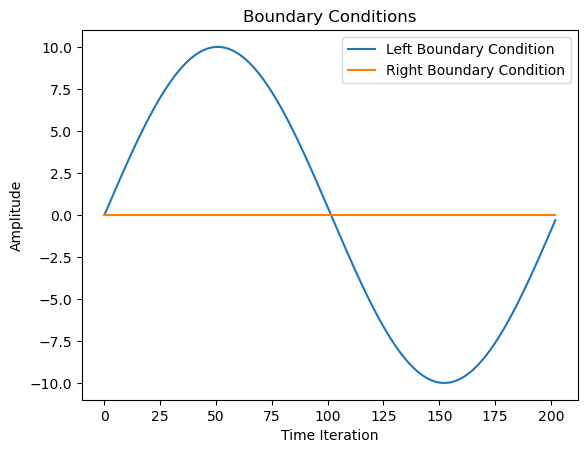

In [ ]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.sparse.linalg as la
import scipy.sparse as sparse
import time as tm
import logging
from scipy.sparse import diags
from scipy.sparse import csr_matrix

distance = 1 # meters
frequency = 1 # hertz
omega = 2 * np.pi * frequency

grid1 = 50 # cells total
grid = 2* grid1 + 1 
n = grid
amplitude = 10 # meters

#matrices
xvalueM = np.arange(grid)/grid
dx = xvalueM[1]-xvalueM[0]
diffusivity = 5e-1
dt = 1/(2 * grid + 1)
r = dt * diffusivity / (dx * dx)


# initialization
X = np.arange(grid) * dx  
T =  0*np.sin(2 * np.pi * X)


T[-1] = 0 


I = sparse.identity(grid, format='csr')
difop = diffusionOperator (grid) * r
operatorMat = I - difop
operatorMat[0, 0] = 1
operatorMat[-1, -1] = 1




operator1 = harmonicOperatorMatrix(frequency,n)
operator2 = laplacianeOperator(n)*diffusivity/(dx*dx)
operator3 = BCOperatorMatrix(n)

operator = operator1 + operator2 + operator3



# RHS matrix 
RHS = np.zeros((2*n+1,2*n+1),float)
time = np.arange(2*n+1)*dt
RHS[:,0] = amplitude * np.sin(2 * np.pi*frequency * time)
RHS[:,-1] = -0*amplitude * np.sin(2 * np.pi*frequency * time)
plt.plot(RHS[:,0], label ="Left Boundary Condition")
plt.plot(RHS[:,-1], label ="Right Boundary Condition")
plt.legend()
plt.title("Boundary Conditions")
plt.xlabel("Time Iteration")
plt.ylabel("Amplitude")
plt.show()

RHS = RHS.reshape((2*n+1)**2)


solution = la.spsolve(operator, RHS)
solution = solution.reshape(2*n+1,2*n+1)




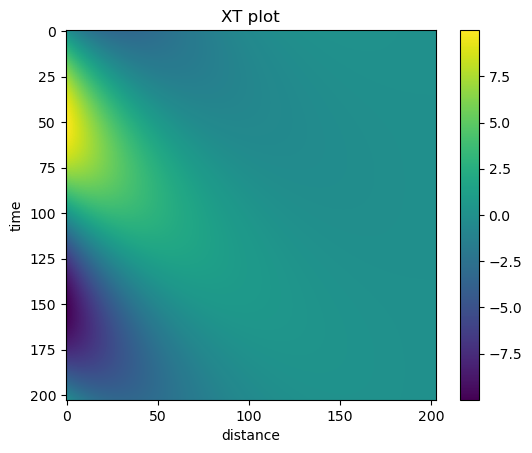

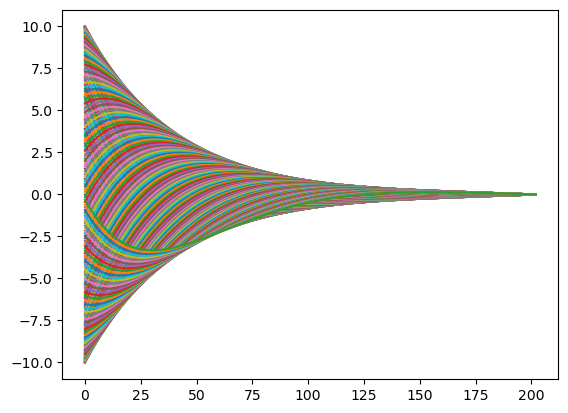

In [52]:
plt.imshow(solution)
plt.colorbar()
plt.xlabel("distance")
plt.ylabel("time")
plt.title("XT plot")
plt.show()
for a in np.arange(2*n+1):
    plt.plot(solution[a,:])
    #plt.show()